In [32]:
from openff.toolkit import Molecule, Topology, ForceField
from openff.interchange import Interchange
from openmm.unit import kelvin, picoseconds, nanometer, kilojoule, mole, dalton, angstrom, kilocalorie, nanosecond, femtosecond
from openmm import LangevinIntegrator, State, VerletIntegrator
from openmm.app import Simulation, DCDReporter, StateDataReporter, CheckpointReporter
from openmm.unit.quantity import Quantity
from sys import stdout
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import copy

In [33]:
from openmm.app.forcefield import ForceField as OpenMMForceField
from openmm.app import PDBFile

In [81]:
def animate_md(r:np.array, topology):
    # Setup the figure and axes...
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set(xlim=(-3.5, 3.5), ylim=(-3.5, 3.5), ylabel='Angstrom',
           xlabel='Angstrom', title=f'{next(topology.molecules).name} movement')
    
    ## drawing and animating 
    scat = ax.scatter(r[0,:,0], r[0,:,1], marker='o', c=range(topology.n_atoms), s=1000)
    
    def animate(i):
        scat.set_offsets(r[100*i])
    
    ani = animation.FuncAnimation(fig, animate, frames=int(n/ 100))
    plt.close()
    return HTML(ani.to_jshtml())

In [136]:
### 3. Choose parameters of the experiment
temperature = 100*kelvin
frictionCoeff = 0  # 1/picoseconds
time_step = 0.0002*picoseconds
total_steps = int(1*picoseconds / time_step)

smiles_explicit_h = Molecule.from_smiles(
    #"[H][C]([H])([H])[C@@]([H])([C](=[O])[O-])[N+]([H])([H])[H]",
    "N1N=NN=N1",
    hydrogens_are_explicit=False,
)
smiles_explicit_h.generate_conformers(n_conformers=1)

sage = ForceField("openff_unconstrained-2.1.0.offxml")
interchange = Interchange.from_smirnoff(sage, [smiles_explicit_h])

positions = interchange.positions.to_openmm()
system = interchange.to_openmm_system()
topology = Topology.from_molecules([smiles_explicit_h])

original_positions = copy.deepcopy(interchange
                                   .to_openmm_simulation(
                                       LangevinIntegrator(temperature, frictionCoeff, time_step)
                                   )
                                   .context.getState(getPositions=True).getPositions())
original_positions_numpy = copy.deepcopy(interchange
                                   .to_openmm_simulation(
                                       LangevinIntegrator(temperature, frictionCoeff, time_step)
                                   )
                                   .context.getState(getPositions=True).getPositions(True))
positions[0][0] += Quantity(0.05, nanometer)

## Straight up OpenMM MD

In [83]:
integrator = VerletIntegrator(time_step)
simulation = Simulation(topology.to_openmm(), system, integrator)
simulation.context.setPositions(positions)
#simulation.minimizeEnergy()

In [84]:
for i, f in enumerate(system.getForces()):
    f.setForceGroup(i)

In [85]:
r = np.empty((total_steps, topology.n_atoms, 3)) 
for n in range(total_steps):
    simulation.step(1)
    state = simulation.context.getState(getForces=True, getPositions=True, getVelocities=True, getEnergy=True)
    r[n] = state.getPositions(True) * 10  # nanometer -> angstrom
    if n % 1000 == 0:
        #print(state.getForces())
        print(state.getKineticEnergy())
animate_md(r, topology)

13.521360637283228 kJ/mol
454.2146383312811 kJ/mol
433.0773231914647 kJ/mol
281.8969564839833 kJ/mol
191.36567122071568 kJ/mol


In [39]:
for i, f in enumerate(system.getForces()):
    state = simulation.context.getState(getForces=True, groups={i})
    print(f.getName(), state.getForces())

Nonbonded force [Vec3(x=4995.621467505969, y=-3775.069426127392, z=4366.9627501585055), Vec3(x=1462.8677623839753, y=5847.673007555172, z=-294.8464904863257), Vec3(x=-919.5802041617306, y=-1284.7570688481637, z=-1337.0951689098492), Vec3(x=-4599.137403223323, y=-2084.209885255929, z=-220.27861570824575), Vec3(x=1250.7057594041607, y=1025.578274655536, z=-810.648266179812), Vec3(x=-2190.477381909051, y=270.78509802077673, z=-1704.0942088742727)] kJ/(nm mol)
PeriodicTorsionForce [Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0)] kJ/(nm mol)
HarmonicAngleForce [Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0)] kJ/(nm mol)
HarmonicBondForce [Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0

## OpenMM MD without Harmonic Bond Length Forces

In [40]:
system_no_blf = interchange.to_openmm_system()
system_no_blf.removeForce(3)  # seems like bond length force is this one currently

for i, f in enumerate(system.getForces()):
    f.setForceGroup(i)

integrator = VerletIntegrator(time_step)
simulation_no_blf = Simulation(topology.to_openmm(), system_no_blf, integrator)
simulation_no_blf.context.setPositions(positions)


In [41]:
r = np.empty((total_steps, topology.n_atoms, 3)) 
for n in range(total_steps):
    simulation_no_blf.step(1)
    state = simulation_no_blf.context.getState(getForces=True, 
                                               getPositions=True, 
                                               getVelocities=True, 
                                               getEnergy=True)
    r[n] = state.getPositions(True) * 10  # nanometer -> angstrom
    if n % 1000 == 0:
        #print(state.getForces())
        print(state.getKineticEnergy())
animate_md(r, topology)

0.46406843486118776 kJ/mol
195.95089431364224 kJ/mol
228.69973573127788 kJ/mol
219.38410124669778 kJ/mol
233.83735881626612 kJ/mol


Ensure that we really didn't have bond length forces

In [42]:
for i, f in enumerate(system_no_blf.getForces()):
    state = simulation_no_blf.context.getState(getForces=True, groups={i})
    print(f.getName(), state.getForces())

Nonbonded force [Vec3(x=8.439975081654955, y=-3.660248911127468, z=-7.446313769596578), Vec3(x=-1.244334021448596, y=-8.382289806832896, z=9.371982722900839), Vec3(x=24.492104824742505, y=9.643557247607392, z=5.625045136888962), Vec3(x=-35.899048020462644, y=-28.941106019504865, z=-10.045507118720058), Vec3(x=4.610720284568618, y=31.991630504923833, z=1.8808654481846272), Vec3(x=-0.3994181490548384, y=-0.6515430150659949, z=0.61392758034221)] kJ/(nm mol)
PeriodicTorsionForce [Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0)] kJ/(nm mol)
HarmonicAngleForce [Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0), Vec3(x=0.0, y=0.0, z=0.0)] kJ/(nm mol)


## Add in my own Bond length force

In [43]:
system_no_blf = interchange.to_openmm_system()
system_no_blf.removeForce(3)  # seems like bond length force is this one currently
integrator = VerletIntegrator(time_step)
simulation_no_blf = Simulation(topology.to_openmm(), system_no_blf, integrator)
simulation_no_blf.context.setPositions(positions)

In [103]:
bonds = sage.get_parameter_handler("Bonds").find_matches(topology)  # k units: kCal / Angstrom **2 / mole; length units: Angstrom
m = Quantity(np.array([[atom.mass.m] for atom in topology.atoms]), dalton)   # Dalton
def get_f(r, topology, bonds):
    f = Quantity(np.zeros_like(r), kilojoule/(nanometer*mole))
    for i in range(topology.n_atoms):
        for j in range(topology.n_atoms):
            if i != j and bonds.get((i,j)):
                rij = r[i] - r[j]
                rij_abs = np.linalg.norm(rij)
                k = bonds.get((i,j)).parameter_type.k.to_openmm()
                r0 = bonds.get((i,j)).parameter_type.length.to_openmm()
                f[i] -= k * (rij_abs - r0) * rij / rij_abs 
    return f


In [45]:
r = np.empty((total_steps, topology.n_atoms, 3)) 
for n in range(total_steps):
    state = simulation_no_blf.context.getState(getForces=True, 
                                               getPositions=True, 
                                               getVelocities=True, 
                                               getEnergy=True)
    f = get_f(state.getPositions(), topology, bonds)
    v = state.getVelocities() + f * time_step / m
    p = state.getPositions() + time_step * v
    simulation_no_blf.context.setPositions(p)
    simulation_no_blf.context.setVelocities(v)
    simulation_no_blf.step(1)
    r[n] = state.getPositions(True) * 10  # nanometer -> angstrom
    if n % 1000 == 0:
        #print(state.getForces())
        print(state.getKineticEnergy())
animate_md(r, topology)

0.051617104463949515 kJ/mol
221.73071269557235 kJ/mol
229.94850102441785 kJ/mol
128.8627264993445 kJ/mol
112.07890118699522 kJ/mol


## Add in my own linearized bond length force

In [46]:
import scipy


def compute_jacobian(r_ini, topology):
    '''The function computes the Jacobian of the spring potential evaluated
    at the initial positions of the particles.'''
    n = np.size(r_ini)
    J = Quantity(np.zeros((n, n)), kilocalorie / mole)
    for i in range(topology.n_atoms):
        for j in range(topology.n_atoms):
            if i == j:
                for other in np.arange(topology.n_atoms)[np.arange(topology.n_atoms) != i]:
                    RiRother = r_ini[i] - r_ini[other]
                    riother = np.linalg.norm(RiRother) ** 2
                    if bonds.get((i,other)):
                        k = bonds.get((i,other)).parameter_type.k.to_openmm()
                        r0 = bonds.get((i,other)).parameter_type.length.to_openmm() ** 2
                    else:
                        k = Quantity(0, kilocalorie / angstrom ** 2 / mole)
                        r0 = Quantity(0, nanometer) ** 2
                    l = 4 * k * Quantity(np.outer(RiRother, RiRother))
                    r = 2 * k * (riother - r0) * np.eye(3)
                    J[i * 3: (i+1) * 3, j * 3: (j+1) * 3] -= l + r
            else:
                RiRj = r_ini[i] - r_ini[j]
                rij = np.linalg.norm(RiRj) ** 2
                if bonds.get((i,j)):
                    k = bonds.get((i,j)).parameter_type.k.to_openmm()
                    r0 = bonds.get((i,j)).parameter_type.length.to_openmm() **2
                else:
                    k = Quantity(0, kilocalorie / angstrom ** 2 / mole)
                    r0 = Quantity(0, nanometer) **2
                l = 4 * k * Quantity(np.outer(RiRj,  RiRj))
                r = 2 * k * (rij - r0) * np.eye(3)
                J[i * 3: (i+1) * 3, j * 3: (j+1) * 3] = l + r 
    return J

def get_rotation(v, u):
    F = u.T @ np.array(v)  # .T turns Quantity into np.array. array @ Quantity not defined
    U, S, Vh = scipy.linalg.svd(F)
    R = Vh.T @ U.T
    return R

def get_repeated_rot(r_current, r_old, base_atom_idx, n_atoms):
    RxLarge = np.zeros((n_atoms, n_atoms))
    Rx_invLarge = np.zeros((n_atoms, n_atoms))
    
    relevant_atoms = [base_atom_idx] + [bonded_atom.molecule_atom_index for
                            bonded_atom in topology.atom(base_atom_idx).bonded_atoms]
    Rx = get_rotation(r_current[relevant_atoms], r_old[relevant_atoms])
    RxLarge = np.kron(np.eye(n_atoms), Rx)
    Rx_invLarge = np.kron(np.eye(n_atoms), Rx.T)
    return Quantity(RxLarge), Quantity(Rx_invLarge), Quantity(Rx)

In [47]:
system_no_blf = interchange.to_openmm_system()
system_no_blf.removeForce(3)  # seems like bond length force is this one currently
integrator = VerletIntegrator(time_step)
simulation_no_blf = Simulation(topology.to_openmm(), system_no_blf, integrator)
simulation_no_blf.context.setPositions(positions)

In [48]:
J = compute_jacobian(original_positions, topology)
M_inv = np.kron(np.diag(1 / m.flatten()), np.eye(3))
f0 = get_f(original_positions, topology, bonds)

In [49]:
r = np.empty((total_steps, topology.n_atoms, 3)) 
for n in range(total_steps):
    state = simulation_no_blf.context.getState(getForces=True, 
                                               getPositions=True, 
                                               getVelocities=True, 
                                               getEnergy=True)
    p = state.getPositions(True)
    v = state.getVelocities(True)
    vv = state.getVelocities(True)
    for i in range(topology.n_atoms):
        RxLarge, Rx_invLarge, Rx = get_repeated_rot(state.getPositions(True),
                                                original_positions_numpy,
                                                i, 
                                                topology.n_atoms)
        """
        A = np.eye(*J.shape) - time_step ** 2 * np.matmul(M_inv, RxLarge) @ (np.matmul(J, Rx_invLarge))
        b = vv.flatten()
        b += time_step.value_in_unit(nanosecond) * np.matmul(M_inv, \
                    (Quantity(np.stack(f0).flatten()) + Quantity(RxLarge @ 
                        (np.matmul(J, 
                         (np.matmul(Rx_invLarge, Quantity(np.stack(p).flatten()) - \
                          Quantity(np.stack(original_positions).flatten()))))
                        ))
                    )
                                     )
        v_i_1 = np.linalg.solve(A, b)
        v[i] = Quantity(v_i_1[i*3 : (i+1)*3], v.unit)
        """
        force_substitute = Quantity(
            Rx @ (np.array(J) @ (Rx_invLarge @ p.flatten() - original_positions_numpy.flatten()))[i*3 : (i+1)*3],
            kilojoule/(nanometer*mole))
        v[i] = vv[i] + time_step / m[i] * (force_substitute)
         #v = np.reshape(v_i_1, (topology.n_atoms,3))
    p = state.getPositions() + time_step * v
    simulation_no_blf.context.setPositions(p)
    simulation_no_blf.context.setVelocities(v)
    simulation_no_blf.step(1)
    r[n] = state.getPositions(True) * 10  # nanometer -> angstrom
    if n % 1000 == 0:
        #print(state.getForces())
        print(state.getKineticEnergy())
animate_md(r, topology)

0.051617104463949515 kJ/mol
72.07143378311234 kJ/mol
185.56868004874133 kJ/mol
246.9376419559851 kJ/mol
136.32983377545688 kJ/mol


## With global rotation approach

In [50]:
def get_Rx(r_current, r_old, topology):
    RxLarge = np.zeros((r_current.size, r_current.size))
    Rx_invLarge = np.zeros((r_current.size, r_current.size))
    for i in range(topology.n_atoms):
        relevant_atoms = list(range(topology.n_atoms))
        Rx = get_rotation(r_current[relevant_atoms], r_old[relevant_atoms])
        RxLarge[i*3: (i+1)*3, i*3: (i+1)*3] = Rx
        Rx_invLarge[i*3: (i+1)*3, i*3: (i+1)*3] = Rx.T
    return RxLarge, Rx_invLarge

In [51]:
system_no_blf = interchange.to_openmm_system()
system_no_blf.removeForce(3)  # seems like bond length force is this one currently
integrator = VerletIntegrator(time_step)
simulation_no_blf = Simulation(topology.to_openmm(), system_no_blf, integrator)
simulation_no_blf.context.setPositions(positions)

In [52]:
J = compute_jacobian(original_positions, topology)
M_inv = np.kron(np.diag(1 / m.flatten()), np.eye(3))
f0 = get_f(original_positions, topology, bonds)

In [53]:
r = np.empty((total_steps, topology.n_atoms, 3)) 
for n in range(total_steps):
    state = simulation_no_blf.context.getState(getForces=True, 
                                               getPositions=True, 
                                               getVelocities=True, 
                                               getEnergy=True)
    p = state.getPositions(True)
    v = state.getVelocities(True)
    RxLarge, Rx_invLarge = get_Rx(p, original_positions_numpy, topology)
    v = Quantity(v.flatten() + time_step * M_inv @ (RxLarge @ np.array(J) @ \
        (Rx_invLarge @ p.flatten() - original_positions_numpy.flatten())),
                 nanometer / picoseconds)
    
    v = v.reshape((topology.n_atoms,3))
    p = state.getPositions(True) + time_step * v
    simulation_no_blf.context.setPositions(p)
    simulation_no_blf.context.setVelocities(v)
    simulation_no_blf.step(1)
    r[n] = state.getPositions(True) * 10  # nanometer -> angstrom
    if n % 1000 == 0:
        #print(state.getForces())
        print(state.getKineticEnergy())
animate_md(r, topology)

0.051617104463949515 kJ/mol
73.34470496903116 kJ/mol
62.56808390434289 kJ/mol
70.40520336512084 kJ/mol
38.60101789782851 kJ/mol


## Analytic approach

In [154]:
system_no_blf = interchange.to_openmm_system()
system_no_blf.removeForce(3)  # seems like bond length force is this one currently
integrator = VerletIntegrator(time_step)
simulation_no_blf = Simulation(topology.to_openmm(), system_no_blf, integrator)
simulation_no_blf.context.setPositions(positions)

In [155]:
J = compute_jacobian(original_positions, topology)
M_inv = np.kron(np.diag(1 / m.flatten()), np.eye(3))
f0 = get_f(original_positions, topology, bonds)

In [156]:
time_step = 1e-5*femtosecond
T = 0.02*femtosecond
total_steps = int(T / time_step)
sampling_steps = int(sampling_interval/ time_step)

In [157]:
r = np.empty((total_steps, topology.n_atoms, 3)) 
for n in range(total_steps):
    state = simulation_no_blf.context.getState(getForces=True, 
                                               getPositions=True, 
                                               getVelocities=True, 
                                               getEnergy=True)
    p = state.getPositions(True)
    v = state.getVelocities(True)
    X = np.concatenate((p, v)).flatten()
    RxLarge, Rx_invLarge = get_Rx(p, original_positions_numpy, topology)
    A = M_inv @ RxLarge @ np.array(J) @ Rx_invLarge
    Lambda_t = state.getForces(True).flatten() - \
        M_inv @ RxLarge @ np.array(J) @ Rx_invLarge @ original_positions_numpy.flatten()
    Kappa_t = np.zeros_like(X)
    Kappa_t[p.size:] = Lambda_t
    U = np.block([[np.zeros((p.size, p.size)), np.eye(p.size)],
                  [A, np.zeros((v.size, v.size))]])
    exp_t_U = scipy.linalg.expm(time_step * U)
    #X_1 = exp_t_U @ X + 1/2 * time_step * (Kappa_1 + exp_t_U @ Kappa_t)
    # really bad, left rectangle integration
    #X_1 = exp_t_U @ X + np.array(time_step * (exp_t_U @ Kappa_t))
    # Hochbruck & Ostermann (2010) simplest approximation
    X_1 = exp_t_U @ X + np.array(time_step * 
                                 np.linalg.solve(
                                     (time_step * U),
                                     (exp_t_U - np.eye(Kappa_t.size))@ Kappa_t)
                                )
    
    v = X_1[p.size:].reshape((topology.n_atoms,3))
    p = X_1[:p.size].reshape((topology.n_atoms,3))
    simulation_no_blf.context.setPositions(p)
    simulation_no_blf.context.setVelocities(v)
    simulation_no_blf.step(1)
    r[n] = state.getPositions(True) * 10  # nanometer -> angstrom
    if n % 1000 == 0:
        #print(state.getForces())
        print(state.getKineticEnergy())
animate_md(r, topology)

1.290427611598738e-10 kJ/mol
657.8950585433723 kJ/mol


In [160]:
r[0:4]

array([[[ 1.17814744e+00, -4.41030759e-03, -1.39212222e-01],
        [ 8.78317692e-02,  1.05150034e+00, -6.53154496e-01],
        [-1.08289256e+00,  6.58517027e-01, -1.11302510e+00],
        [-1.20443372e+00, -6.29077814e-01, -8.80339745e-01],
        [-1.15819945e-01, -1.04348878e+00, -2.77323549e-01],
        [ 1.63716702e+00, -3.30404727e-02,  3.16342278e-01]],

       [[-2.94417443e+00, -1.13294946e+01,  2.42536089e+00],
        [-4.03448520e+00, -1.02735804e+01,  1.91141892e+00],
        [-5.20521085e+00, -1.06665675e+01,  1.45154877e+00],
        [-5.32675192e+00, -1.19541606e+01,  1.68423379e+00],
        [-4.23813751e+00, -1.23685748e+01,  2.28725061e+00],
        [-2.48515116e+00, -1.13581236e+01,  2.88091565e+00]],

       [[-1.84213883e+01, -3.71839036e+00,  2.89583160e+01],
        [-1.95116844e+01, -2.66246553e+00,  2.84443749e+01],
        [-2.06824140e+01, -3.05546415e+00,  2.79845061e+01],
        [-2.08039548e+01, -4.34305192e+00,  2.82171901e+01],
        [-1.97153385

# Relative error
Let's try to approach a reproduction of the first plot in [1]. There the relative errors in location space of different integration schemes are compared. The reference simulation is using a standard technique with very short time steps.

[1] D. L. Michels and M. Desbrun, “A semi-analytical approach to molecular dynamics,” Journal of Computational Physics, vol. 303, pp. 336–354, Dec. 2015, doi: 10.1016/j.jcp.2015.10.009.


In [73]:
### 3. Choose parameters of the experiment
time_step = 1e-7*femtosecond
T = 0.02*femtosecond
total_steps = int(T / time_step)
sampling_interval = 1e-2*femtosecond 
sampling_steps = int(sampling_interval/ time_step)

smiles_explicit_h = Molecule.from_smiles(
    "[H][C]([H])([H])[C@@]([H])([C](=[O])[O-])[N+]([H])([H])[H]",
    #"N1N=NN=N1",
    hydrogens_are_explicit=False,
)
smiles_explicit_h.generate_conformers(n_conformers=1)

sage = ForceField("openff_unconstrained-2.1.0.offxml")
interchange = Interchange.from_smirnoff(sage, [smiles_explicit_h])

positions = interchange.positions.to_openmm()
system = interchange.to_openmm_system()
topology = Topology.from_molecules([smiles_explicit_h])

original_positions = copy.deepcopy(interchange
                                   .to_openmm_simulation(
                                       LangevinIntegrator(temperature, frictionCoeff, time_step)
                                   )
                                   .context.getState(getPositions=True).getPositions())
original_positions_numpy = copy.deepcopy(interchange
                                   .to_openmm_simulation(
                                       LangevinIntegrator(temperature, frictionCoeff, time_step)
                                   )
                                   .context.getState(getPositions=True).getPositions(True))
bonds = sage.get_parameter_handler("Bonds").find_matches(topology)  # k units: kCal / Angstrom **2 / mole; length units: Angstrom
m = Quantity(np.array([[atom.mass.m] for atom in topology.atoms]), dalton)   # Dalton

In [55]:
system = interchange.to_openmm_system()
integrator = VerletIntegrator(time_step)
simulation = Simulation(topology.to_openmm(), system, integrator)
simulation.context.setPositions(positions)
t = 0 * femtosecond
""" Already ran this
while t < T:
    t += sampling_interval
    simulation.step(sampling_steps)
    simulation.saveState(f"States/reference_{t.value_in_unit(femtosecond):.7f}.state")
"""    

' Already ran this\nwhile t < T:\n    t += sampling_interval\n    simulation.step(sampling_steps)\n    simulation.saveState(f"States/reference_{t.value_in_unit(femtosecond):.7f}.state")\n'

In [56]:
def get_md_positions_explicit(time_step, T, sampling_interval, interchange, topology, positions, bonds):
    total_steps = int(T / time_step)
    sampling_steps = int(sampling_interval/ time_step)
    
    system_no_blf = interchange.to_openmm_system()
    system_no_blf.removeForce(3)  # seems like bond length force is this one currently
    integrator = VerletIntegrator(time_step)
    simulation_no_blf = Simulation(topology.to_openmm(), system_no_blf, integrator)
    simulation_no_blf.context.setPositions(positions)

    r = np.empty((int(total_steps / sampling_steps), topology.n_atoms, 3)) 
    for n in range(total_steps):
        state = simulation_no_blf.context.getState(getForces=False, 
                                                   getPositions=True, 
                                                   getVelocities=True, 
                                                   getEnergy=True)
        f = get_f(state.getPositions(), topology, bonds)
        v = state.getVelocities() + f * time_step / m
        p = state.getPositions() + time_step * v
        simulation_no_blf.context.setPositions(p)
        simulation_no_blf.context.setVelocities(v)
        simulation_no_blf.step(1)
        if n % sampling_steps == 0:
            #print(state.getForces())
            print(state.getKineticEnergy())
            r[n // sampling_steps] = simulation_no_blf.context.getState(getPositions=True).getPositions(True)
    return r

In [57]:
r = get_md_positions_explicit(1e-4*femtosecond, T, sampling_interval, interchange, topology, positions, bonds)
r2 = get_md_positions_explicit(1e-3*femtosecond, T, sampling_interval, interchange, topology, positions, bonds)
r3 = get_md_positions_explicit(1e-2*femtosecond, T, sampling_interval, interchange, topology, positions, bonds)
r4 = get_md_positions_explicit(2*1e-4*femtosecond, T, sampling_interval, interchange, topology, positions, bonds)

3.5264553125173995e-09 kJ/mol
0.0007717158492039477 kJ/mol
3.5264553125173985e-07 kJ/mol
0.0007851503983665668 kJ/mol
3.5264553125174e-05 kJ/mol
0.000950925942883439 kJ/mol
1.4105821250069598e-08 kJ/mol
0.0007731801219011148 kJ/mol


In [58]:
def get_md_positions_linearized(time_step, T, sampling_interval, interchange, topology, positions, original_positions, bonds):
    total_steps = int(T / time_step)
    sampling_steps = int(sampling_interval/ time_step)
    
    system_no_blf = interchange.to_openmm_system()
    system_no_blf.removeForce(3)  # seems like bond length force is this one currently
    integrator = VerletIntegrator(time_step)
    simulation_no_blf = Simulation(topology.to_openmm(), system_no_blf, integrator)
    simulation_no_blf.context.setPositions(positions)

    J = compute_jacobian(original_positions, topology)
    M_inv = np.kron(np.diag(1 / m.flatten()), np.eye(3))
    f0 = get_f(original_positions, topology, bonds)
    
    r = np.empty((int(total_steps / sampling_steps), topology.n_atoms, 3)) 
    for n in range(total_steps):
        state = simulation_no_blf.context.getState(getForces=False, 
                                                   getPositions=True, 
                                                   getVelocities=True, 
                                                   getEnergy=True)
        p = state.getPositions(True)
        v = state.getVelocities(True)
        vv = state.getVelocities(True)
        for i in range(topology.n_atoms):
            RxLarge, Rx_invLarge, Rx = get_repeated_rot(state.getPositions(True),
                                                    original_positions_numpy,
                                                    i, 
                                                    topology.n_atoms)
            force_substitute = Quantity(
            Rx @ (np.array(J) @ (Rx_invLarge @ p.flatten() - original_positions_numpy.flatten()))[i*3 : (i+1)*3],
            kilojoule/(nanometer*mole))
            v[i] = vv[i] + time_step / m[i] * (force_substitute)
        p = state.getPositions() + time_step * v
        simulation_no_blf.context.setPositions(p)
        simulation_no_blf.context.setVelocities(v)
        simulation_no_blf.step(1)
        if n % sampling_steps == 0:
            #print(state.getForces())
            print(state.getKineticEnergy())
            r[n // sampling_steps] = simulation_no_blf.context.getState(getPositions=True).getPositions(True)
    return r

In [59]:
l = get_md_positions_linearized(1e-4*femtosecond, T, sampling_interval, interchange, topology, positions, original_positions, bonds)
l2 = get_md_positions_linearized(1e-3*femtosecond, T, sampling_interval, interchange, topology, positions, original_positions, bonds)
l3 = get_md_positions_linearized(1e-2*femtosecond, T, sampling_interval, interchange, topology, positions, original_positions, bonds)
l4 = get_md_positions_linearized(2*1e-4*femtosecond, T, sampling_interval, interchange, topology, positions, original_positions, bonds)

3.5264553125173995e-09 kJ/mol
0.00014247212436458302 kJ/mol
3.5264553125173985e-07 kJ/mol
0.00015551616445337035 kJ/mol
3.5264553125174e-05 kJ/mol
0.0003173800295862011 kJ/mol
1.4105821250069598e-08 kJ/mol
0.00014389306043526652 kJ/mol


Text(0, 0.5, 'Sum relative position errors')

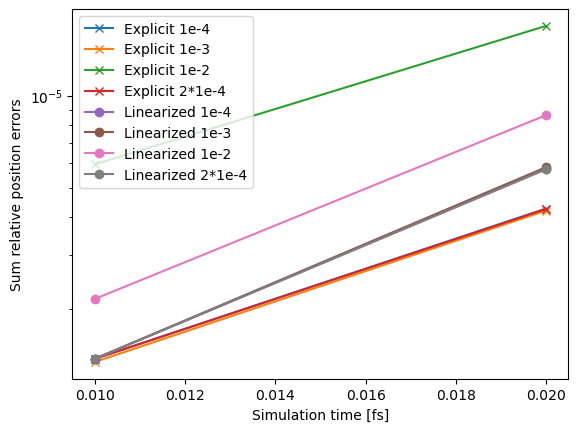

In [60]:
reference_positions = np.empty_like(r)
for i in range(len(r)):
    simulation.loadState(
        f"States/reference_{(i + 1)*sampling_interval.value_in_unit(femtosecond):.7f}.state"
    )
    reference_positions[i] = simulation.context.getState(getPositions=True).getPositions(True)
    
xticks = np.linspace(sampling_interval.value_in_unit(femtosecond),
                     T.value_in_unit(femtosecond),
                     total_steps // sampling_steps)
plt.plot(xticks, (np.linalg.norm(reference_positions - r, axis=2) / np.linalg.norm(reference_positions, axis=2)).sum(1),
         label="Explicit 1e-4", marker="x")
plt.plot(xticks, (np.linalg.norm(reference_positions - r2, axis=2) / np.linalg.norm(reference_positions, axis=2)).sum(1),
         label="Explicit 1e-3", marker="x")
plt.plot(xticks, (np.linalg.norm(reference_positions - r3, axis=2) / np.linalg.norm(reference_positions, axis=2)).sum(1),
         label="Explicit 1e-2", marker="x")
plt.plot(xticks, (np.linalg.norm(reference_positions - r4, axis=2) / np.linalg.norm(reference_positions, axis=2)).sum(1),
         label="Explicit 2*1e-4", marker="x")

plt.plot(xticks, (np.linalg.norm(reference_positions - l, axis=2) / np.linalg.norm(reference_positions, axis=2)).sum(1),
         label="Linearized 1e-4", marker="o")
plt.plot(xticks, (np.linalg.norm(reference_positions - l2, axis=2) / np.linalg.norm(reference_positions, axis=2)).sum(1),
         label="Linearized 1e-3", marker="o")
plt.plot(xticks, (np.linalg.norm(reference_positions - l3, axis=2) / np.linalg.norm(reference_positions, axis=2)).sum(1),
         label="Linearized 1e-2", marker="o")
plt.plot(xticks, (np.linalg.norm(reference_positions - l4, axis=2) / np.linalg.norm(reference_positions, axis=2)).sum(1),
         label="Linearized 2*1e-4", marker="o")
plt.legend()
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("Simulation time [fs]")
plt.ylabel("Sum relative position errors")
